In [1]:
!pip install albumentations==0.4.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 32.5 MB/s 
     |████████████████████████████████| 948 kB 53.7 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=08bf92e15fce72696b71dc7d82de7948f95ec0f8069755086ae815f2cb6b503f
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
PATH = '/content/drive/MyDrive/Colab Notebooks/data'

In [5]:
import os
os.listdir(PATH)

['val_masks', 'val_images', 'train_images', 'train_masks']

In [6]:
train_img = os.path.join(PATH,'train_images')
train_mask = os.path.join(PATH,'train_masks')
val_img = os.path.join(PATH,'val_images')
val_mask = os.path.join(PATH,'val_masks')

In [7]:
len(os.listdir(train_img))

312

In [8]:
len(os.listdir(train_mask))

312

In [9]:
len(os.listdir(val_img))

48

In [10]:
len(os.listdir(val_mask))

48

Library Import

In [11]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets,transforms
from tqdm import tqdm
import cv2
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import os
import torch.nn.functional as F

In [12]:
# config
LEARNING_RATE = 1e-4
SPLIT=0.2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4
EPOCHS = 4
NUM_WORKERS = 4
IMAGE_HEIGHT = 572
IMAGE_WIDTH = 572
PIN_MEMORY = True

Dataset

In [13]:
class CarvanaDataset(Dataset):
    def __init__(self,images,image_dir,mask_dir,transform=None,train=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.isTrain = train
        self.images = images
    def __len__(self):
        return len(self.images)
    def __getitem__(self,index):
        img_path = os.path.join(self.image_dir,self.images[index])
        mask_path = os.path.join(self.mask_dir,self.images[index].replace(".jpg","_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"),dtype=np.float32)
        mask[mask == 255.0] = 1.0
        
        if self.transform is not None:
            augmentations = self.transform(image=image,mask=mask)
            image = augmentations['image']
            mask = augmentations['mask']
            
        return {"image":image,"mask":mask}

In [14]:
images = os.listdir(train_img)
masks = os.listdir(train_mask)

(1280, 1918, 3)


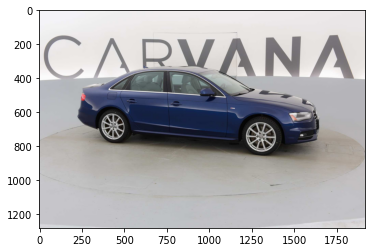

In [15]:
img = np.array(Image.open(train_img+"/"+images[0]).convert("RGB"))
plt.imshow(img,cmap="gray")
print(img.shape)

In [16]:
def train_test_split(images,splitSize):
    imageLen = len(images)
    val_len = int(splitSize*imageLen)
    train_len = imageLen - val_len
    train_images,val_images = images[:train_len],images[train_len:]
    return train_images,val_images

Model Fitting Function

In [17]:
def fit(model,dataloader,data,optimizer,criterion):
    print('-------------Training---------------')
    model.train()
    train_running_loss = 0.0
    counter=0
    
    # num of batches
    num_batches = int(len(data)/dataloader.batch_size)
    for i,data in tqdm(enumerate(dataloader),total=num_batches):
        counter+=1
        image,mask = data["image"].to(DEVICE),data["mask"].to(DEVICE)
        optimizer.zero_grad()
        outputs = model(image)
        outputs =outputs.squeeze(1)
        loss = criterion(outputs,mask)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/counter
    return train_loss
def validate(model,dataloader,data,criterion):
    print("\n--------Validating---------\n")
    model.eval()
    valid_running_loss = 0.0
    counter = 0
    # number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    with torch.no_grad():
        for i,data in tqdm(enumerate(dataloader),total=num_batches):
            counter+=1
            image,mask = data["image"].to(DEVICE),data["mask"].to(DEVICE)
            outputs = model(image)
            outputs =outputs.squeeze(1)
            loss = criterion(outputs,mask)
            valid_running_loss += loss.item()
    valid_loss = valid_running_loss/counter
    return valid_loss

UNET Architecture

In [18]:
import torch
import torch.nn as nn


def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )
    return conv.to(DEVICE)


def addPadding(srcShapeTensor, tensor_whose_shape_isTobechanged):

    if(srcShapeTensor.shape != tensor_whose_shape_isTobechanged.shape):
        target = torch.zeros(srcShapeTensor.shape)
        target[:, :, :tensor_whose_shape_isTobechanged.shape[2],
               :tensor_whose_shape_isTobechanged.shape[3]] = tensor_whose_shape_isTobechanged
        return target.to(DEVICE)
    return tensor_whose_shape_isTobechanged.to(DEVICE)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(3, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)

        self.up_trans_1 = nn.ConvTranspose2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=2,
            stride=2
        )
        self.up_conv_1 = double_conv(1024, 512)

        self.up_trans_2 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=2,
            stride=2
        )
        self.up_conv_2 = double_conv(512, 256)

        self.up_trans_3 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=2,
            stride=2
        )
        self.up_conv_3 = double_conv(256, 128)

        self.up_trans_4 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=2,
            stride=2
        )
        self.up_conv_4 = double_conv(128, 64)

        self.out = nn.Conv2d(
            in_channels=64,
            out_channels=1,
            kernel_size=1
        )

    def forward(self, image):
        # expected size
        # encoder (Normal convolutions decrease the size)
        x1 = self.down_conv_1(image)
        # print("x1 "+str(x1.shape))
        x2 = self.max_pool_2x2(x1)
        # print("x2 "+str(x2.shape))
        x3 = self.down_conv_2(x2)
        # print("x3 "+str(x3.shape))
        x4 = self.max_pool_2x2(x3)
        # print("x4 "+str(x4.shape))
        x5 = self.down_conv_3(x4)
        # print("x5 "+str(x5.shape))
        x6 = self.max_pool_2x2(x5)
        # print("x6 "+str(x6.shape))
        x7 = self.down_conv_4(x6)
        # print("x7 "+str(x7.shape))
        x8 = self.max_pool_2x2(x7)
        # print("x8 "+str(x8.shape))
        x9 = self.down_conv_5(x8)
        # print("x9 "+str(x9.shape))

        # decoder (transposed convolutions increase the size)
        x = self.up_trans_1(x9)
        x = addPadding(x7, x)
        x = self.up_conv_1(torch.cat([x7, x], 1))

        x = self.up_trans_2(x)
        x = addPadding(x5, x)
        x = self.up_conv_2(torch.cat([x5, x], 1))

        x = self.up_trans_3(x)
        x = addPadding(x3, x)
        x = self.up_conv_3(torch.cat([x3, x], 1))

        x = self.up_trans_4(x)
        x = addPadding(x1, x)
        x = self.up_conv_4(torch.cat([x1, x], 1))

        x = self.out(x)
        # print(x.shape)
        return x.to(DEVICE)

In [19]:
train_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT,IMAGE_WIDTH),
    A.Rotate(limit=35,p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(
        mean=[0.0,0.0,0.0],
        std = [1.0,1.0,1.0],
        max_pixel_value=255.0
    ),
    ToTensorV2()  
])
validation_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT,IMAGE_WIDTH),
    A.Normalize(
        mean = [0.0,0.0,0.0],
        std = [1.0,1.0,1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2()
])

In [20]:
train_images_path,val_images_path = train_test_split(images,SPLIT)
train_data = CarvanaDataset(train_images_path,train_img,train_mask,train_transform,True)
valid_data = CarvanaDataset(val_images_path,train_img,train_mask,validation_transform,True)
train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
valid_dataloader = DataLoader(valid_data,batch_size=BATCH_SIZE,shuffle=False)

In [21]:
image = train_data.__getitem__(0)["image"].shape
image

torch.Size([3, 572, 572])

Epoch 1 of 4
-------------Training---------------


63it [08:09,  7.77s/it]



--------Validating---------



16it [01:48,  6.81s/it]


Train Loss: 0.3593
Val Loss: 0.3097
Epoch 2 of 4
-------------Training---------------


63it [01:29,  1.43s/it]



--------Validating---------



16it [00:12,  1.31it/s]


Train Loss: 0.2532
Val Loss: 0.2555
Epoch 3 of 4
-------------Training---------------


63it [01:33,  1.48s/it]



--------Validating---------



16it [00:11,  1.33it/s]


Train Loss: 0.2189
Val Loss: 0.1982
Epoch 4 of 4
-------------Training---------------


63it [01:35,  1.52s/it]



--------Validating---------



16it [00:11,  1.34it/s]


Train Loss: 0.1966
Val Loss: 0.1913


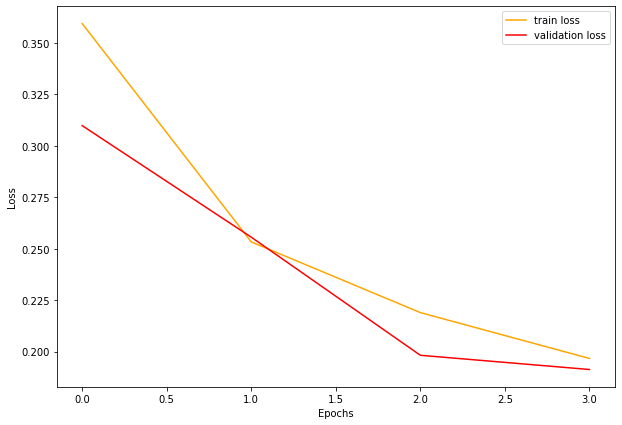


---------DONE TRAINING----------



In [22]:
train_loss = []
val_loss =[]
model = UNet().to(DEVICE)
optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = fit(model, train_dataloader, train_data,optimizer,criterion)
    val_epoch_loss = validate(model, valid_dataloader, valid_data, criterion)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color="orange", label='train loss')
plt.plot(val_loss, color="red", label='validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
# plt.savefig(f"../input/loss.png")
plt.show()
torch.save({
    'epoch': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': criterion,
}, "./model.pth")

print("\n---------DONE TRAINING----------\n")

Dice Loss

In [23]:
import warnings
warnings.filterwarnings('ignore')
import cv2
import numpy as np
from keras import backend as K

In [24]:
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)

In [25]:
y_pred =valid_data.__getitem__(0)["image"]
y_true = train_data.__getitem__(0)["image"]

print(y_pred.shape)
print(y_true.shape)

torch.Size([3, 572, 572])
torch.Size([3, 572, 572])


In [26]:
y_pred1 = y_pred.reshape((-1, 572, 572, 3 ))
y_true1 = y_true.reshape((-1, 572, 572, 3 ))

print(y_pred1.shape)
print(y_true1.shape)

torch.Size([1, 572, 572, 3])
torch.Size([1, 572, 572, 3])


In [27]:
dice_score = dice_coefficient(y_true1, y_pred1)
print ("Dice Coeff: {}".format(dice_score))

Dice Coeff: 0.7066107988357544


Model Testing

torch.Size([572, 572])


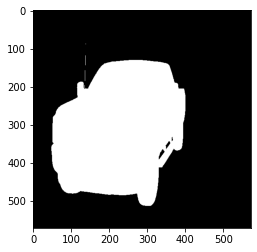

In [28]:
data = train_data.__getitem__(100)
plt.imshow(data['mask'],cmap="gray")
print(train_data.__getitem__(0)['mask'].shape)

torch.Size([3, 572, 572])
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([572, 572])


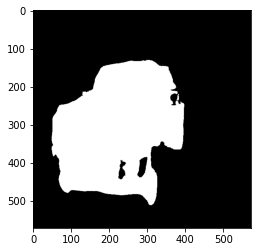

In [29]:
# for Testing on Single datapoint after training
# plt.imshow(np.transpose(np.array(data['image']),(1,2,0)),cmap="gray")
print(data['image'].shape)
img = data['image'].unsqueeze(0).to(device="cuda")
# model = UNet()
output = model(img)
output = torch.squeeze(output)
output[output>0.0] = 1.0
output[output<=0.0]=0
print(torch.max(output))
print(output.shape)
disp = output.detach().cpu()
plt.imshow(disp,cmap="gray")